# Aula 12 - Multi-Armed Bandits - 10-armed testbed

In [1]:
import math

import numpy as np
import matplotlib.pyplot as plt
import time

### Classe TestBed contendo os estados, ações e as configurações gerais do teste

In [2]:
class Testbed(object):

    # Constructor
    def __init__(self, nArms, mean, stDev):

        # Number of arms
        self.nArms = nArms

        # Used for the Gaussian random actions
        self.mean = mean        # Mean
        self.stDev = stDev      # Standard Deviation

        self.actArr = np.zeros(nArms)   # Array to store action values
        self.optim = 0                  # Store optimal value for greedy
        self.reset()

    # Reset testbed for next iteration
    def reset(self):
        # Set random gaussian/normal values using numpy function, requires mean, standard deviation and number of arms
        self.actArr = np.random.normal(self.mean, self.stDev, self.nArms)

        # Identify the maximum value in action array
        self.optim = np.argmax(self.actArr)

In [13]:
tb = Testbed(10, 0, 1)
tb.reset()
print(tb.actArr)
print(tb.optim)

[-0.08620849  0.92945835  0.36161631 -0.56545028 -0.02436189  0.46497002
 -0.75970014 -2.94114819  1.43625086  1.58453643]
9


###  Classe Agent - classe pai para os demais algoritmos

In [4]:
class Agent(object):

    # Constructor
    def __init__(self, nArms):
        self.nArms = nArms      # Number of arms

        self.timeStep = 0                    # Time Step t
        self.lastAction = None               # Store last action

        self.kAction = np.zeros(nArms)          # count of actions taken at time t
        self.rSum = np.zeros(nArms)             # Sums number of rewards
        self.valEstimates = np.zeros(nArms)     # action value estimates sum(rewards)/Amount

    def exploit(self):
        maxReward = np.max(self.valEstimates)
        actions = np.where(self.valEstimates == maxReward)[0]
        a = np.random.choice(actions)

        return a

    # Interpreter - updates the value estimates amounts based on the last action
    def interpreter(self, reward):
        # Add 1 to the number of action taken in step
        At = self.lastAction

        self.kAction[At] += 1       # Add 1 to action selection
        self.rSum[At] += reward     # Add reward to sum array

        # Calculate new action-value, sum(r)/ka
        self.valEstimates[At] = self.rSum[At]/self.kAction[At]

        # Increase time step
        self.timeStep += 1


    # Reset all variables for next iteration
    def reset(self):
        self.timeStep = 0                    # Time Step t
        self.lastAction = None               # Store last action

        self.kAction = np.zeros(nArms)
        self.rSum = np.zeros(nArms)
        self.valEstimates[:] = 0   # action value estimates Qt ~= Q*(a)

### Algoritmos implementados: Random, ExploreOnce, ExploreSteps, UCB1, Thompson

In [5]:
class Random(Agent):
    def __init__(self, nArms):
        super().__init__(nArms)

    def __str__(self):
        return "Random"

    def action(self):
        a = np.random.choice(range(self.nArms))
        self.lastAction = a
        return a


class ExploreOnce(Agent):
    def __init__(self, nArms):
        super().__init__(nArms)        

    def __str__(self):
        return "Explore Once"

    def action(self):
        #zeros = np.where(self.exploredArms == 0)  # Indices where arm == 0
        zeros = np.where(self.kAction == 0)  # Indices where arm == 0
        options = zeros[0].tolist()
        # Explore
        if len(options) > 0:
            a = np.random.choice(options)            
        # Exploit
        else:
            a = self.exploit()

        self.lastAction = a
        return a

    def reset(self):
        super().reset()        

class Epsilon(Agent):
    def __init__(self, nArms, eProb=0):
        super().__init__(nArms)
        self.eProb = eProb      # Epsilon probability

    def __str__(self):
        if self.eProb == 0:
            return "Greedy"
        else:
            return "Epsilon = " + str(self.eProb)

    def action(self):        
        randProb = np.random.random()  # Pick random probability between 0-1
        # Explore
        if randProb < self.eProb:
            a = np.random.choice(len(self.valEstimates))    # Select random action
        # Exploit
        else:
            a = self.exploit()

        self.lastAction = a
        return a


class ExploreSteps(Agent):
    def __init__(self, nArms, eSteps=0):
        super().__init__(nArms)
        self.eSteps = eSteps    # Epsilon by number of steps

    def __str__(self):
        return "Epsilon Steps = " + str(self.eSteps)

    def action(self):
        if self.timeStep < self.eSteps:
            a = np.random.choice(len(self.valEstimates))  # Select random action
        else:
            a = self.exploit()

        self.lastAction = a
        return a

class UCB1(Agent):
    def __init__(self, nArms, nPlays):
        super().__init__(nArms)        
        self.nPlays = nPlays

    def __str__(self):
        return "UCB1"

    def action(self):        
        actions = np.where(self.kAction == 0)[0]
        if len(actions) > 0:
            a = np.random.choice(actions)
        else:
            ucbEstimates = np.zeros(nArms)
            for i in range(nArms):                
                ucbEstimates[i] = self.valEstimates[i] + np.sqrt(2*np.log(self.nPlays)/self.kAction[i])

            maxReward = np.max(ucbEstimates)
            actions = np.where(ucbEstimates == maxReward)[0]
            a = np.random.choice(actions)

        self.lastAction = a        
        return a

    def reset(self):
        super().reset()        

class Thompson(Agent):
    def __init__(self, nArms):
        super().__init__(nArms)
        self.success_count = np.zeros(nArms)
        self.failure_count = np.zeros(nArms)

    def __str__(self):
        return "Thompson Sampling"

    def action(self):
        samples_list = [np.random.beta(1 + self.success_count[bandit_id], 1 + self.failure_count[bandit_id]) for bandit_id in
                        range(nArms)]
        a = np.argmax(samples_list)

        self.lastAction = a
        return a

    def interpreter(self, reward):
        # Add 1 to the number of action taken in step
        At = self.lastAction

        if reward >= 0:
            self.success_count[At] += 1
        else:
            self.failure_count[At] += 1

        # Increase time step
        self.timeStep += 1

    def reset(self):
        super().reset()
        self.success_count = np.zeros(nArms)
        self.failure_count = np.zeros(nArms)


In [6]:
success = [100, 50, 20, 10, 10, 10, 1, 1, 1, 1]
failure = [50, 50, 20, 10, 10, 10, 1, 1, 1, 100]
samples_list = [np.random.beta(success[bandit_id], failure[bandit_id]) for bandit_id in range(10)]
samples_list

[0.6647895226563978,
 0.6508596062655985,
 0.5183990556306949,
 0.6723183325881386,
 0.4841145367507883,
 0.37666447381314444,
 0.29316432331419107,
 0.33320386973690236,
 0.5833524459281098,
 0.00665281886789136]

### Classe Environment - controla os agentes e o testbed

In [7]:
class Environment(object):

    # Constructor
    def __init__(self, testbed, agents, plays, iterations):
        self.testbed = testbed
        self.agents = agents

        self.plays = plays
        self.iterations = iterations


    # Run Test
    def play(self):

        # Array to store the scores, number of plays X number of agents
        scoreArr = np.zeros((self.plays, len(self.agents)))
        # Array to maintain optimal count, Graph 2
        optimlArr = np.zeros((self.plays, len(self.agents)))

        # loop for number of iterations
        for iIter in range(self.iterations):

            # Print statement after every 100 iterations
            if (iIter%100) == 0:
                print("Completed Iterations: ",iIter)

            #Reset testbed and all agents
            self.testbed.reset()
            for agent in self.agents:
                agent.reset()


            # Loop for number of plays
            for jPlays in range(self.plays):
                agtCnt = 0

                for kAgent in self.agents:
                    actionT =  kAgent.action()

                    # Reward - normal dist (Q*(at), variance = 1)
                    rewardT = np.random.normal(self.testbed.actArr[actionT], scale=1)

                    # Agent checks state
                    kAgent.interpreter(reward=rewardT)

                    # Add score in arrary, graph 1
                    scoreArr[jPlays,agtCnt] += rewardT

                    # check the optimal action, add optimal to array, graph 2
                    if actionT == self.testbed.optim:
                        optimlArr[jPlays,agtCnt] += 1

                    agtCnt += 1

        #return averages
        scoreAvg = scoreArr/self.iterations
        optimlAvg = optimlArr/self.iterations

        return scoreAvg, optimlAvg

In [8]:
start_time = time.time()    #store time to monitor execution
nArms = 10                  # n number of bandits
iterations = 2000         # number of repeated iterations
plays = 1000                # number of plays per iteration

# Setup objects to contain infomration about the agents, testbed, and environment
testbed = Testbed(nArms=nArms,mean=0,stDev=1)
agents = [Epsilon(nArms=nArms, eProb=0.1), ExploreSteps(nArms=nArms, eSteps=20), UCB1(nArms=nArms, nPlays=plays), Thompson(nArms=nArms)]
environment = Environment(testbed=testbed,agents=agents,plays=plays,iterations=iterations)

print("Running...")
g1Scores, g2Optimal = environment.play()
print("Execution time: %s seconds" % (time.time() - start_time))


Running...
Completed Iterations:  0
Completed Iterations:  100
Completed Iterations:  200
Completed Iterations:  300
Completed Iterations:  400
Completed Iterations:  500
Completed Iterations:  600
Completed Iterations:  700
Completed Iterations:  800
Completed Iterations:  900
Completed Iterations:  1000
Completed Iterations:  1100
Completed Iterations:  1200
Completed Iterations:  1300
Completed Iterations:  1400
Completed Iterations:  1500
Completed Iterations:  1600
Completed Iterations:  1700
Completed Iterations:  1800
Completed Iterations:  1900
Execution time: 268.2848610877991 seconds


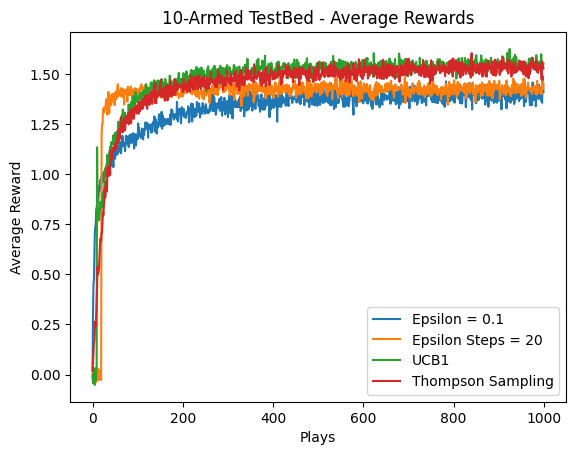

In [9]:
#Graph 1 - Averate rewards over all plays
plt.title("10-Armed TestBed - Average Rewards")
plt.plot(g1Scores)
plt.ylabel('Average Reward')
plt.xlabel('Plays')
plt.legend(agents, loc=4)
plt.show()

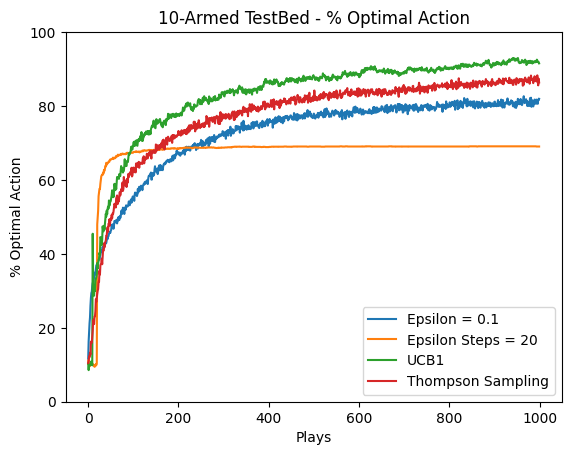

In [10]:
#Graph 1 - optimal selections over all plays
plt.title("10-Armed TestBed - % Optimal Action")
plt.plot(g2Optimal * 100)
plt.ylim(0, 100)
plt.ylabel('% Optimal Action')
plt.xlabel('Plays')
plt.legend(agents, loc=4)
plt.show()